In [45]:
import pandas as pd
from scipy import stats
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

### Load, Clean Data + EDA

In [2]:
pur_behaviour = pd.read_csv("QVI_purchase_behaviour.csv")
pur_behaviour.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


LIFESTAGE: Customer attribute that identifies whether a customer has a family or not and what point in life they are at e.g. are their children in pre-school/primary/secondary school.

PREMIUM_CUSTOMER: Customer segmentation used to differentiate shoppers by the price point of products they buy and the types of products they buy. It is used to identify whether customers may spend more for quality or brand or whether they will purchase the cheapest options.

In [3]:
# Check the dtype for the column we will join
pur_behaviour['LYLTY_CARD_NBR'].map(type).unique()

array([<class 'int'>], dtype=object)

In [4]:
pur_behaviour['LIFESTAGE'].unique()

array(['YOUNG SINGLES/COUPLES', 'YOUNG FAMILIES', 'OLDER SINGLES/COUPLES',
       'MIDAGE SINGLES/COUPLES', 'NEW FAMILIES', 'OLDER FAMILIES',
       'RETIREES'], dtype=object)

In [5]:
pur_behaviour['PREMIUM_CUSTOMER'].unique()

array(['Premium', 'Mainstream', 'Budget'], dtype=object)

In [6]:
tr_data = pd.read_excel("QVI_transaction_data.xlsx")
tr_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [7]:
tr_data['LYLTY_CARD_NBR'].map(type).unique()

array([<class 'int'>], dtype=object)

In [8]:
len(tr_data)

264836

In [9]:
# Number of different stores
len(tr_data['STORE_NBR'].unique())

272

In [10]:
merged_df = pd.merge(
    pur_behaviour,
    tr_data,
    on="LYLTY_CARD_NBR",
    how="left"
)

print(merged_df.shape)
merged_df.head()

(264836, 10)


,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,1000,YOUNG SINGLES/COUPLES,Premium,43390,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,1002,YOUNG SINGLES/COUPLES,Mainstream,43359,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7
2,1003,YOUNG FAMILIES,Budget,43531,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6
3,1003,YOUNG FAMILIES,Budget,43532,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0
4,1004,OLDER SINGLES/COUPLES,Mainstream,43406,1,5,96,WW Original Stacked Chips 160g,1,1.9


Number of rows for merged_df and transcation data are the same so no duplicates where created

In [12]:
# function to check if a column has mixed types or Null values
def class_types(series):
    return list(series.map(type).unique())

summary = pd.DataFrame({
    "Column": merged_df.columns,
    "Dtype": merged_df.dtypes.values,
    "Null Count": merged_df.isnull().sum().values,
    "Null %": (merged_df.isnull().mean().values * 100).round(2),
    "Mixed Types": [len(class_types(merged_df[col])) > 1 for col in merged_df.columns],
    "Class Types": [class_types(merged_df[col]) for col in merged_df.columns]
})

summary

,Column,Dtype,Null Count,Null %,Mixed Types,Class Types
0,LYLTY_CARD_NBR,int64,0,0.0,False,[<class 'int'>]
1,LIFESTAGE,object,0,0.0,False,[<class 'str'>]
2,PREMIUM_CUSTOMER,object,0,0.0,False,[<class 'str'>]
3,DATE,int64,0,0.0,False,[<class 'int'>]
4,STORE_NBR,int64,0,0.0,False,[<class 'int'>]
5,TXN_ID,int64,0,0.0,False,[<class 'int'>]
6,PROD_NBR,int64,0,0.0,False,[<class 'int'>]
7,PROD_NAME,object,0,0.0,False,[<class 'str'>]
8,PROD_QTY,int64,0,0.0,False,[<class 'int'>]
9,TOT_SALES,float64,0,0.0,False,[<class 'float'>]


In [13]:
# Change "DATE" column to date format
merged_df['DATE'] = pd.to_datetime(merged_df['DATE'], unit='D', origin='1899-12-30')
merged_df.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,1000,YOUNG SINGLES/COUPLES,Premium,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,1002,YOUNG SINGLES/COUPLES,Mainstream,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7
2,1003,YOUNG FAMILIES,Budget,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6
3,1003,YOUNG FAMILIES,Budget,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0
4,1004,OLDER SINGLES/COUPLES,Mainstream,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9


In [14]:
# def clean_prod_name(name):
#     if pd.isna(name):
#         return name
#     # Remove numbers and special characters except spaces
#     name = re.sub(r'[^A-Za-z\s]', '', name)
#     # Remove trailing 'g' or 'G' if it's the last character
#     name = re.sub(r'\s*[gG]$', '', name)
#     # Remove extra spaces
#     name = re.sub(r'\s+', ' ', name).strip()
#     return name

# merged_df['PROD_NAME'] = merged_df['PROD_NAME'].apply(clean_prod_name)
# merged_df.head()

In [15]:
merged_df['PROD_NAME'].unique()

array(['Natural Chip        Compny SeaSalt175g',
       'Red Rock Deli Chikn&Garlic Aioli 150g',
       'Grain Waves Sour    Cream&Chives 210G',
       'Natural ChipCo      Hony Soy Chckn175g',
       'WW Original Stacked Chips 160g', 'Cheetos Puffs 165g',
       'Infuzions SourCream&Herbs Veg Strws 110g',
       'RRD SR Slow Rst     Pork Belly 150g',
       'Doritos Cheese      Supreme 330g', 'Doritos Mexicana    170g',
       'Old El Paso Salsa   Dip Tomato Med 300g',
       'GrnWves Plus Btroot & Chilli Jam 180g',
       'Smiths Crinkle Cut  Chips Barbecue 170g',
       'Kettle Sensations   Camembert & Fig 150g',
       'Doritos Corn Chip Southern Chicken 150g',
       'CCs Tasty Cheese    175g', 'Tostitos Splash Of  Lime 175g',
       'Kettle 135g Swt Pot Sea Salt', 'RRD Salt & Vinegar  165g',
       'Infuzions Mango     Chutny Papadums 70g',
       'Smiths Crinkle Cut  Snag&Sauce 150g',
       'Smiths Crinkle      Original 330g',
       'RRD Sweet Chilli &  Sour Cream 165g',
     

In [16]:
remove_keywords = [
    'dip',          # Removes salsa dips and other dips
    'salsa',        # Removes standalone salsa products
    'puffs',        # Removes Cheetos Puffs
    'rings',        # Removes Burger Rings and Cheese Rings
    'cheezels',     # Removes Cheezels
    'twisties',     # Removes Twisties
    'crackers',     # Removes prawn crackers and similar
    'papadums',     # Removes papadum-based snacks
    'prawn',        # Removes prawn crackers
    'french fries', # Removes ambiguous product
    'balls'         # Removes Cheetos Cheese Bacon Balls
]

# Create a regex pattern from the keywords
pattern = '|'.join(remove_keywords)

# Filter out rows containing any of the removal keywords
filtered_df = merged_df[~merged_df['PROD_NAME'].str.contains(pattern, case=False)]

In [17]:
filtered_df.describe()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,2.191410e+05,219141,219141.000000,2.191410e+05,219141.000000,219141.000000,219141.000000
mean,1.356345e+05,2018-12-30 01:34:06.293482752,135.149036,1.352330e+05,55.374531,1.908680,7.351897
min,1.000000e+03,2018-07-01 00:00:00,1.000000,1.000000e+00,1.000000,1.000000,1.700000
25%,7.002800e+04,2018-09-30 00:00:00,70.000000,6.765700e+04,27.000000,2.000000,5.800000
50%,1.310770e+05,2018-12-30 00:00:00,131.000000,1.353830e+05,52.000000,2.000000,7.400000
75%,2.031070e+05,2019-03-31 00:00:00,203.000000,2.027500e+05,83.000000,2.000000,8.800000
max,2.373711e+06,2019-06-30 00:00:00,272.000000,2.415841e+06,114.000000,200.000000,650.000000
std,8.077644e+04,NaN,76.789843,7.816967e+04,33.283574,0.688716,3.128433


In [18]:
high_quantity = filtered_df[filtered_df['PROD_QTY'] > 10]
print(high_quantity[['LYLTY_CARD_NBR', 'PROD_QTY', 'TOT_SALES']])

        LYLTY_CARD_NBR  PROD_QTY  TOT_SALES
221625          226000       200      650.0
221626          226000       200      650.0


In [19]:
high_sales = filtered_df[filtered_df['TOT_SALES'] > 50]  # Adjust threshold
print(high_sales[['PROD_QTY', 'TOT_SALES']])

        PROD_QTY  TOT_SALES
221625       200      650.0
221626       200      650.0


<Axes: xlabel='PROD_QTY'>

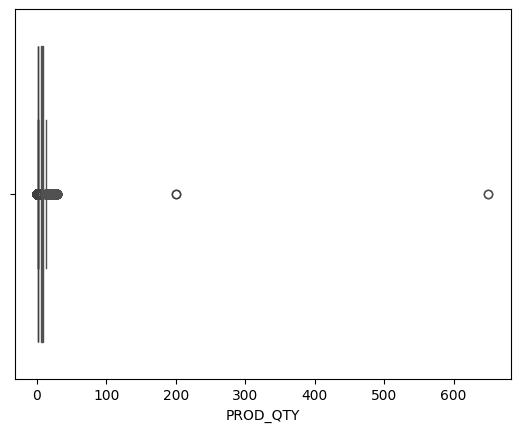

In [20]:
sns.boxplot(data=filtered_df, x='PROD_QTY')
sns.boxplot(data=filtered_df, x='TOT_SALES')

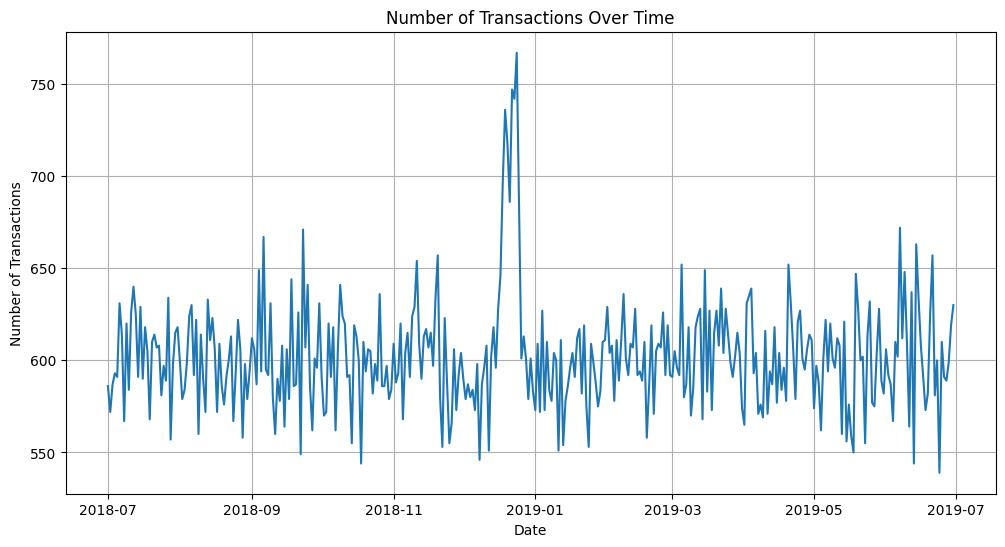

Number of missing dates: 1
Missing dates: DatetimeIndex(['2018-12-25'], dtype='datetime64[ns]', freq=None)


In [21]:
# Count transactions by date
transactions_by_date = filtered_df.groupby('DATE').size().reset_index(name='TXN_COUNT')

# Plot the transaction counts over time
plt.figure(figsize=(12, 6))
plt.plot(transactions_by_date['DATE'], transactions_by_date['TXN_COUNT'])
plt.title('Number of Transactions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()

# Check for missing dates in the sequence
date_range = pd.date_range(start=transactions_by_date['DATE'].min(), 
                           end=transactions_by_date['DATE'].max())
missing_dates = date_range.difference(transactions_by_date['DATE'])
print(f"Number of missing dates: {len(missing_dates)}")
if len(missing_dates) > 0:
    print(f"Missing dates: {missing_dates}")

We are missing this date because the stores where closed on Christmass day

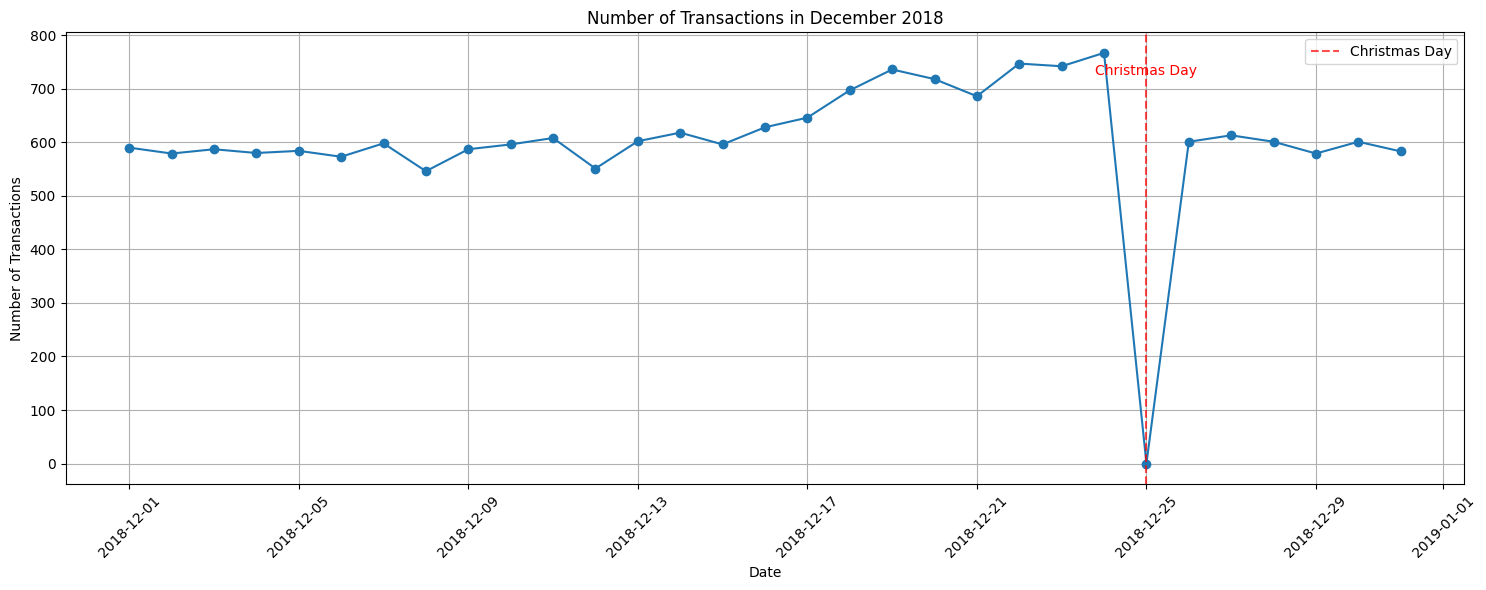

In [22]:
december_2018 = filtered_df[(filtered_df['DATE'].dt.month == 12) & (filtered_df['DATE'].dt.year == 2018)]

# Count transactions by date in December 2018
december_transactions = december_2018.groupby('DATE').size().reset_index(name='TXN_COUNT')

# Create a complete date range for December 2018
dec_2018_dates = pd.date_range(start='2018-12-01', end='2018-12-31', freq='D')
complete_dec_df = pd.DataFrame({'DATE': dec_2018_dates})

# Merge with our transaction data to include all dates
december_complete = pd.merge(complete_dec_df, december_transactions, on='DATE', how='left')
december_complete['TXN_COUNT'] = december_complete['TXN_COUNT'].fillna(0)  # Fill missing dates with 0

# Create a more detailed plot for December 2018
plt.figure(figsize=(15, 6))
plt.plot(december_complete['DATE'], december_complete['TXN_COUNT'], marker='o')
plt.title('Number of Transactions in December 2018')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.xticks(rotation=45)

# Highlight Christmas Day
christmas_day = datetime(2018, 12, 25)
plt.axvline(x=christmas_day, color='r', linestyle='--', alpha=0.7, label='Christmas Day')
plt.text(christmas_day, plt.ylim()[1]*0.9, 'Christmas Day', color='r', ha='center')

plt.legend()
plt.tight_layout()
plt.show()

In [23]:
filtered_df = filtered_df[filtered_df['PROD_QTY'] != 200]
print(filtered_df[['PROD_QTY', 'TOT_SALES']].describe())

            PROD_QTY      TOT_SALES
count  219139.000000  219139.000000
mean        1.906872       7.346032
std         0.340879       2.453134
min         1.000000       1.700000
25%         2.000000       5.800000
50%         2.000000       7.400000
75%         2.000000       8.800000
max         5.000000      29.500000


In [24]:
filtered_df['PACK_SIZE'] = filtered_df['PROD_NAME'].str.findall(r'(\d+)[gG]').str[-1].astype(float)

# Check the extracted values
print(filtered_df['PACK_SIZE'].value_counts().sort_index())

PACK_SIZE
90.0      3008
110.0    19213
134.0    25102
135.0     3257
150.0    38765
160.0     2970
165.0    13849
170.0    19983
175.0    64972
180.0     1468
200.0     4473
210.0     6272
330.0     9391
380.0     6416
Name: count, dtype: int64


<Axes: >

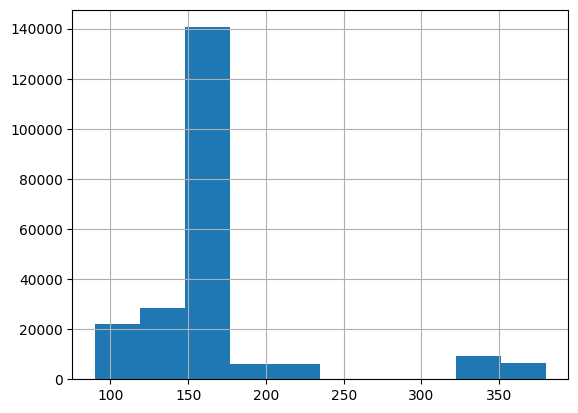

In [25]:
filtered_df['PACK_SIZE'].hist()

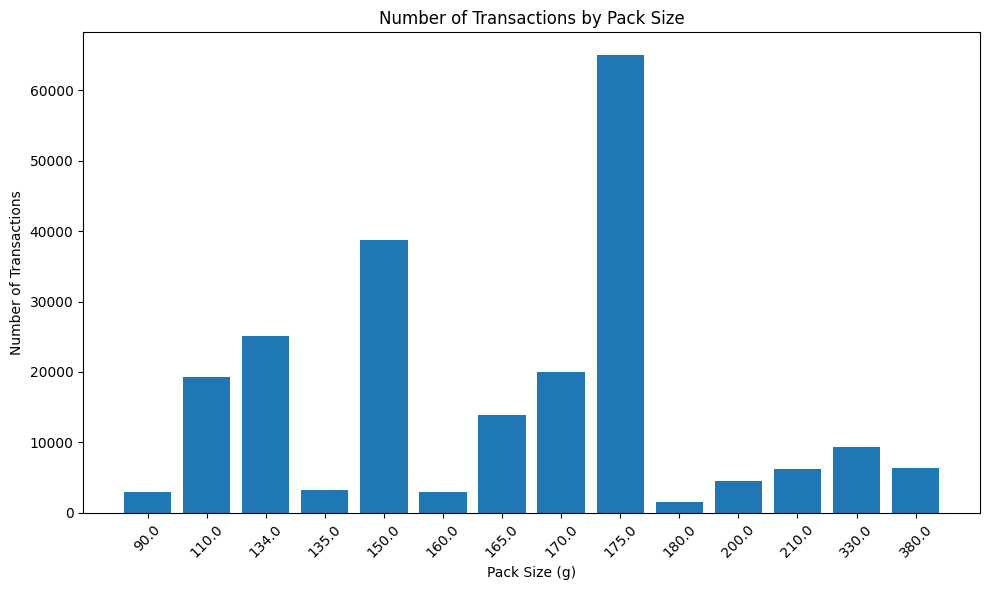

In [26]:
transactions_per_pack = filtered_df.groupby('PACK_SIZE')['TXN_ID'].count()

plt.figure(figsize=(10, 6))
plt.bar(transactions_per_pack.index.astype(str), transactions_per_pack.values)
plt.xlabel('Pack Size (g)')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions by Pack Size')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
filtered_df['BRAND'] = filtered_df['PROD_NAME'].str.split().str[0].str.replace(r'[^a-zA-Z0-9&]+$', '', regex=True)
print(filtered_df['BRAND'].value_counts().head(20))

BRAND
Kettle       41288
Smiths       25952
Pringles     25102
Doritos      22041
Thins        14075
RRD          11894
WW           10320
Cobs          9693
Tostitos      9471
Tyrrells      6442
Infuzions     6376
Grain         6272
Natural       6050
CCs           4551
Red           4427
Dorito        3183
Infzns        3144
Smith         2963
Snbts         1576
GrnWves       1468
Name: count, dtype: int64


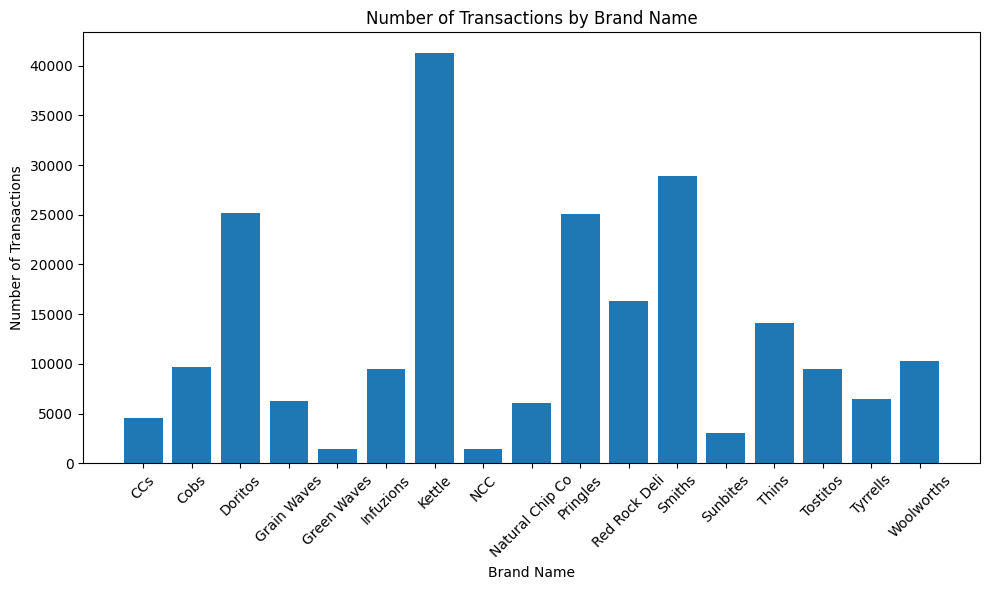

In [34]:
expanded_mapping = {
    'RRD': 'Red Rock Deli',
    'Red': 'Red Rock Deli',
    'Dorito': 'Doritos',
    'Infzns': 'Infuzions',
    'Smith': 'Smiths',
    'Snbts': 'Sunbites',
    'GrnWves': 'Green Waves',
    'WW': 'Woolworths',
    'Grain': 'Grain Waves',
    'Natural': 'Natural Chip Co',
}

filtered_df['BRAND'] = filtered_df['BRAND'].replace(expanded_mapping)

transactions_per_brand = filtered_df.groupby('BRAND')['TXN_ID'].count()

plt.figure(figsize=(10, 6))
plt.bar(transactions_per_brand.index.astype(str), transactions_per_brand.values)
plt.xlabel('Brand Name')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions by Brand Name')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


LIFESTAGE Value Counts:
LIFESTAGE
OLDER SINGLES/COUPLES     45170
RETIREES                  41346
OLDER FAMILIES            39962
YOUNG FAMILIES            35847
YOUNG SINGLES/COUPLES     30201
MIDAGE SINGLES/COUPLES    20799
NEW FAMILIES               5814
Name: count, dtype: int64

PREMIUM_CUSTOMER Value Counts:
PREMIUM_CUSTOMER
Mainstream    84536
Budget        76937
Premium       57666
Name: count, dtype: int64


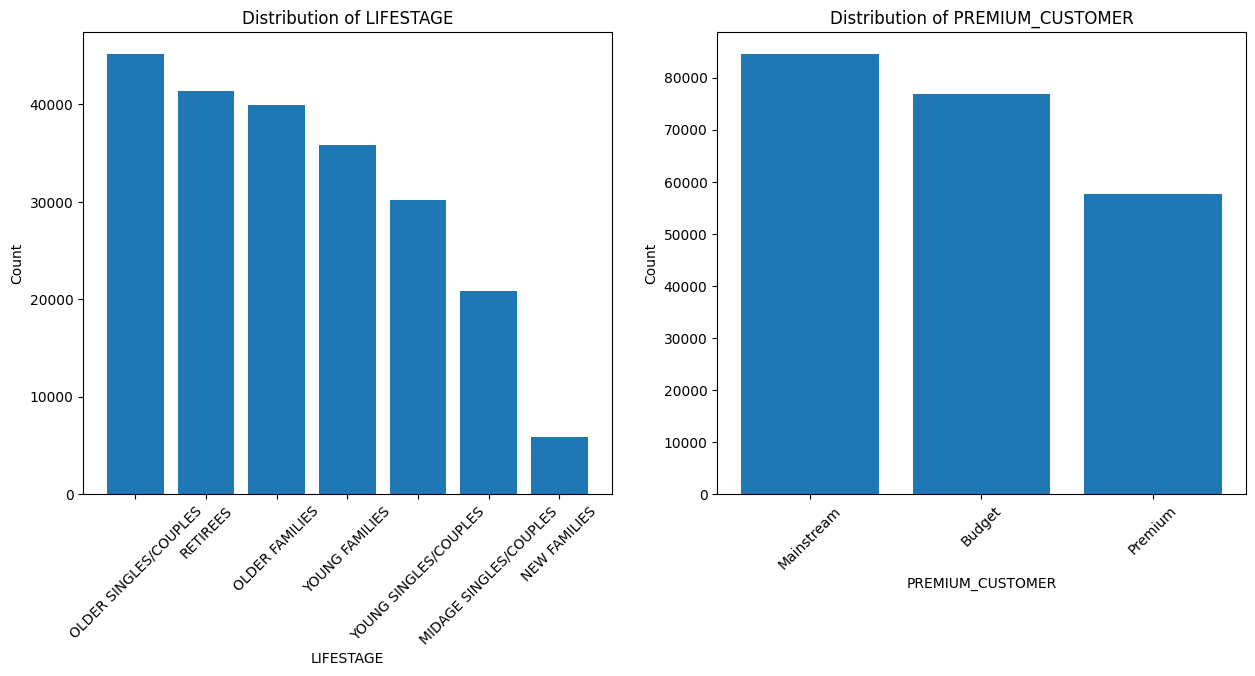

In [29]:
# Summary statistics for categorical columns
print("\nLIFESTAGE Value Counts:")
print(filtered_df['LIFESTAGE'].value_counts())

print("\nPREMIUM_CUSTOMER Value Counts:")
print(filtered_df['PREMIUM_CUSTOMER'].value_counts())

# Visualize the distributions
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# LIFESTAGE distribution
lifestage_counts = filtered_df['LIFESTAGE'].value_counts()
axes[0].bar(lifestage_counts.index.astype(str), lifestage_counts.values)
axes[0].set_title('Distribution of LIFESTAGE')
axes[0].set_xlabel('LIFESTAGE')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# PREMIUM_CUSTOMER distribution
premium_counts = filtered_df['PREMIUM_CUSTOMER'].value_counts()
axes[1].bar(premium_counts.index.astype(str), premium_counts.values)
axes[1].set_title('Distribution of PREMIUM_CUSTOMER')
axes[1].set_xlabel('PREMIUM_CUSTOMER')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

### Save Cleaned dataset

In [30]:
# filtered_df.to_csv('quantium_task1_cleaned.csv', index=False)

In [31]:
df = pd.read_csv('quantium_task1_cleaned.csv')
df.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND
0,1000,YOUNG SINGLES/COUPLES,Premium,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175.0,Natural Chip Co
1,1002,YOUNG SINGLES/COUPLES,Mainstream,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150.0,Red Rock Deli
2,1003,YOUNG FAMILIES,Budget,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210.0,Grain Waves
3,1003,YOUNG FAMILIES,Budget,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175.0,Natural Chip Co
4,1004,OLDER SINGLES/COUPLES,Mainstream,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160.0,Woolworths


In [41]:
# Pull 100 transactions per store (or all transactions if a store has <100)
# sample_df = df.groupby("STORE_NBR").apply(
#     lambda x: x.sample(n=100, random_state=42) if len(x) >= 100 else x
# ).reset_index(drop=True)

# sample_df.shape

(25399, 8)

In [39]:
segment_summary = df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).agg(
    total_sales=('TOT_SALES', 'sum'),
    num_customers=('LYLTY_CARD_NBR', 'nunique'),
    total_quantity=('PROD_QTY', 'sum')
).reset_index()

# Calculate derived metrics
segment_summary['chips_per_customer'] = segment_summary['total_quantity'] / segment_summary['num_customers']
segment_summary['avg_chip_price'] = segment_summary['total_sales'] / segment_summary['total_quantity']

# Create a combined segment label for plotting
segment_summary['segment'] = segment_summary['LIFESTAGE'] + ' - ' + segment_summary['PREMIUM_CUSTOMER']

# Sort by total sales for better visualization
segment_summary = segment_summary.sort_values('total_sales', ascending=True)

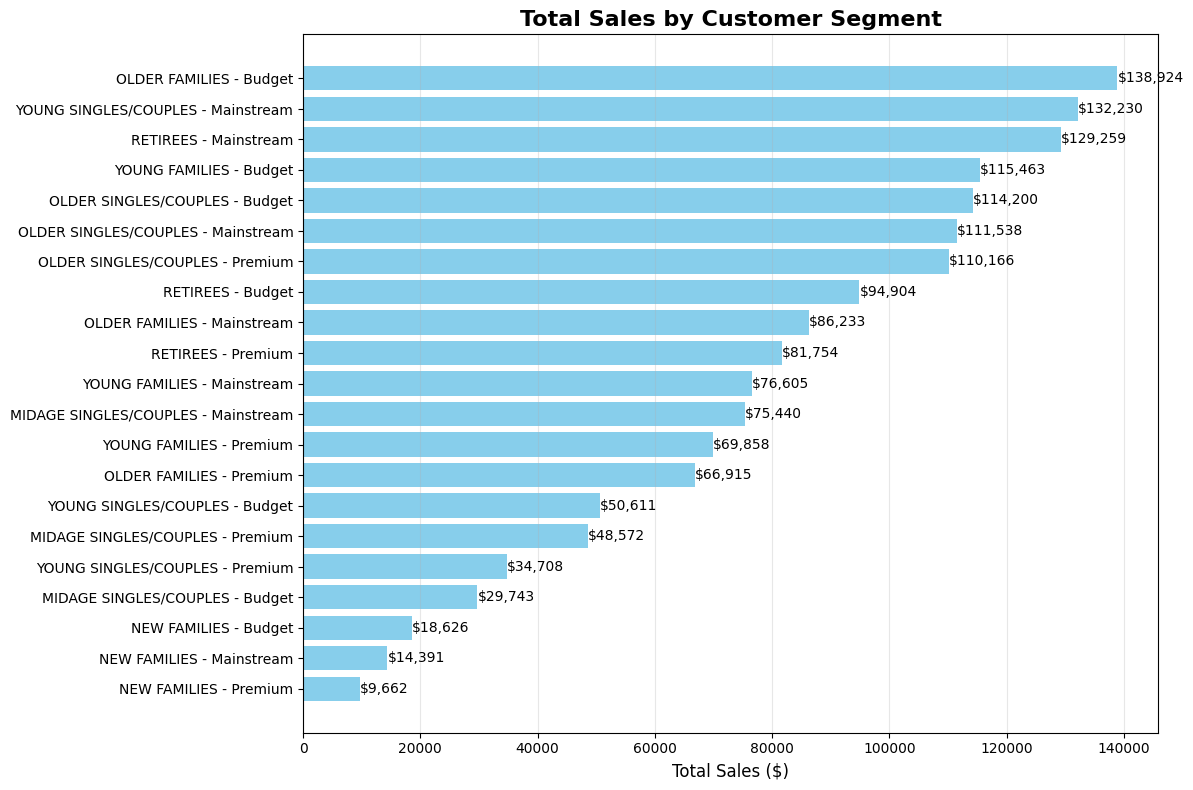

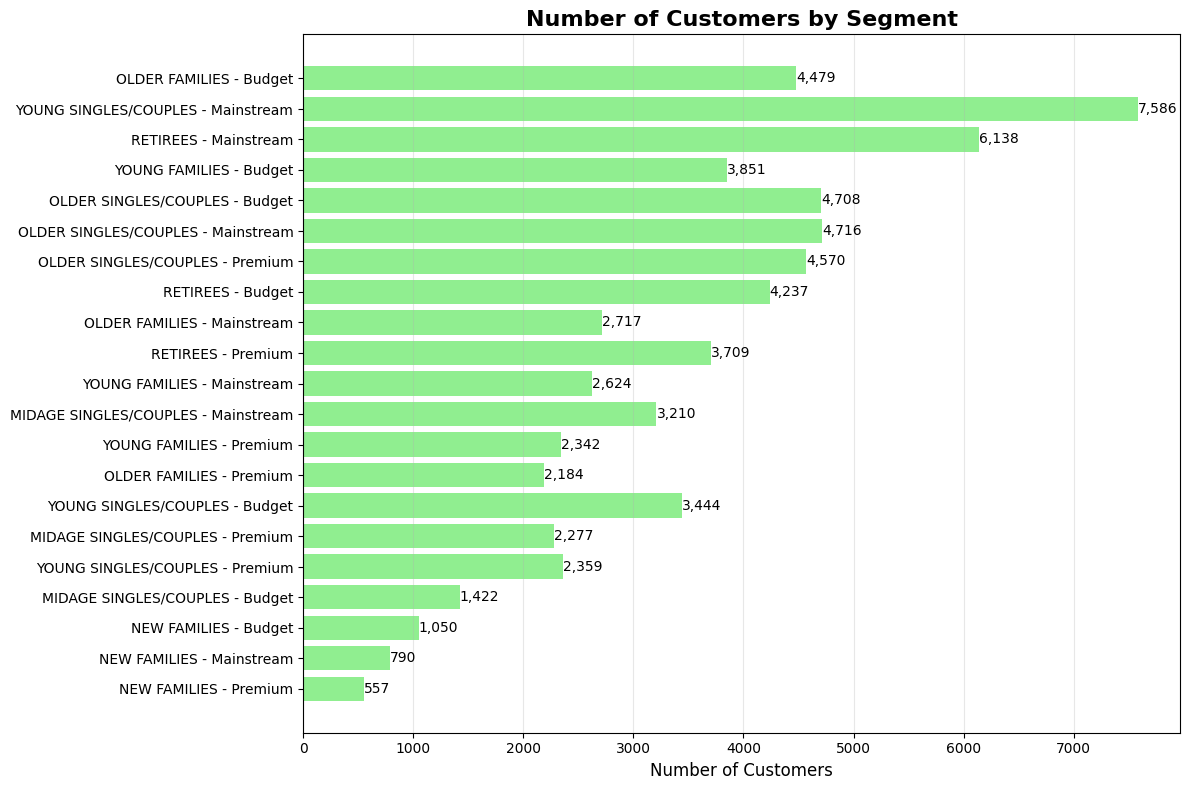

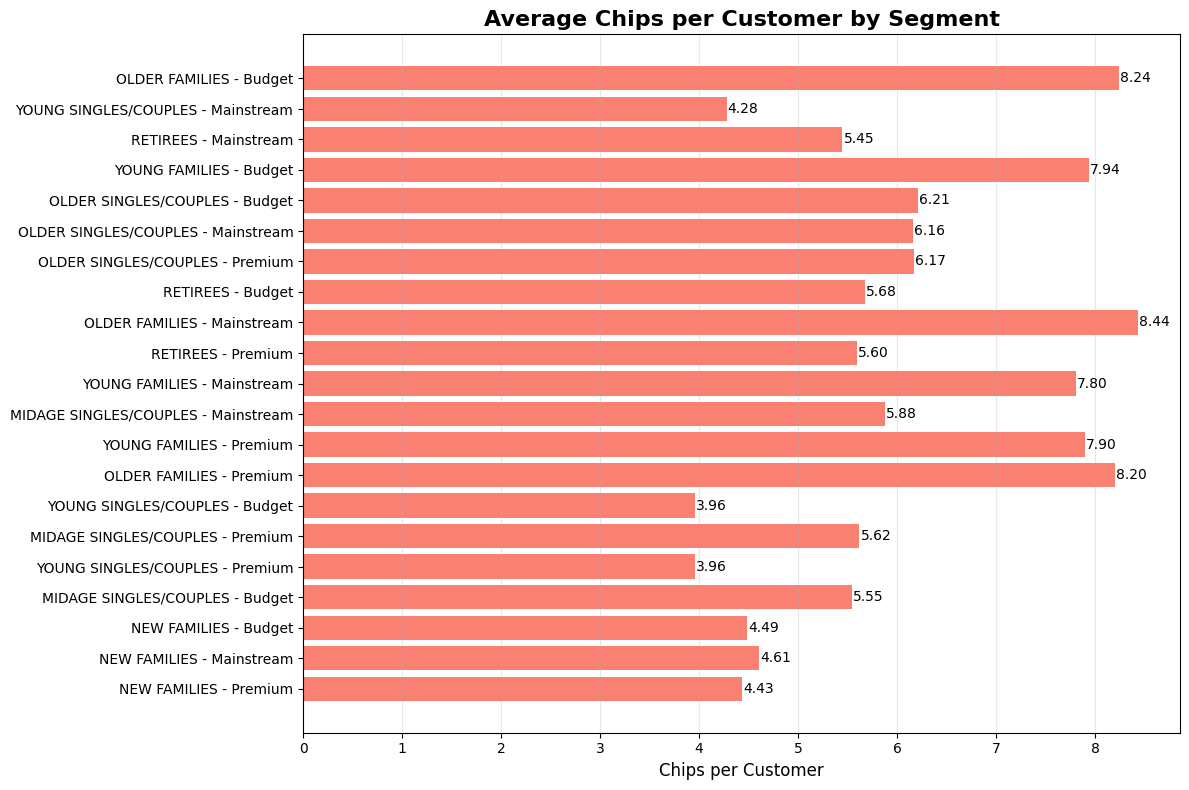

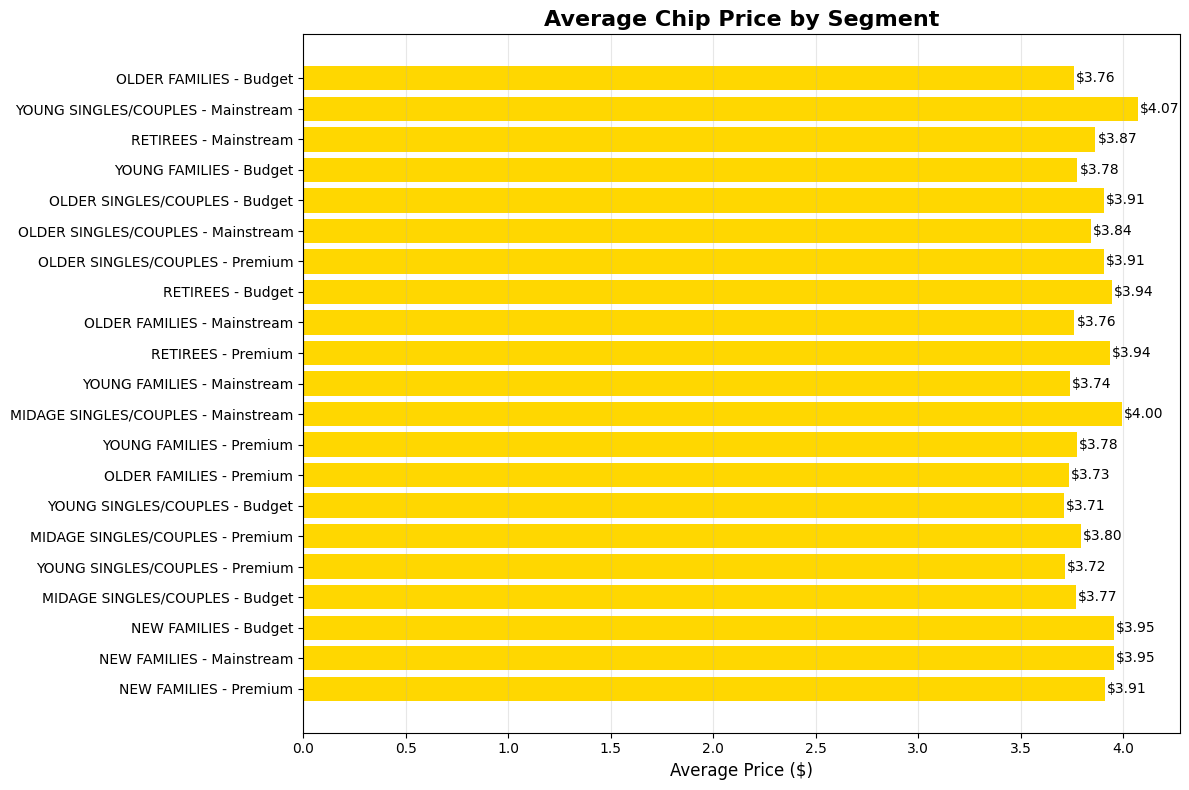


The segment that spends the most on chips is: OLDER FAMILIES - Budget
Total spending: $138,923.65
Number of customers: 4,479
Chips per customer: 8.24
Average chip price: $3.76


In [42]:
# 1. Total Sales by Segment
plt.figure(figsize=(12, 8))
bars = plt.barh(segment_summary['segment'], segment_summary['total_sales'], color='skyblue')
plt.title('Total Sales by Customer Segment', fontsize=16, fontweight='bold')
plt.xlabel('Total Sales ($)', fontsize=12)
plt.grid(axis='x', alpha=0.3)

# Add value labels on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.1, bar.get_y() + bar.get_height()/2,
             f'${width:,.0f}', ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# 2. Number of Customers by Segment
plt.figure(figsize=(12, 8))
bars = plt.barh(segment_summary['segment'], segment_summary['num_customers'], color='lightgreen')
plt.title('Number of Customers by Segment', fontsize=16, fontweight='bold')
plt.xlabel('Number of Customers', fontsize=12)
plt.grid(axis='x', alpha=0.3)

# Add value labels on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.1, bar.get_y() + bar.get_height()/2,
             f'{width:,.0f}', ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# 3. Chips per Customer by Segment
plt.figure(figsize=(12, 8))
bars = plt.barh(segment_summary['segment'], segment_summary['chips_per_customer'], color='salmon')
plt.title('Average Chips per Customer by Segment', fontsize=16, fontweight='bold')
plt.xlabel('Chips per Customer', fontsize=12)
plt.grid(axis='x', alpha=0.3)

# Add value labels on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'{width:.2f}', ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# 4. Average Chip Price by Segment
plt.figure(figsize=(12, 8))
bars = plt.barh(segment_summary['segment'], segment_summary['avg_chip_price'], color='gold')
plt.title('Average Chip Price by Segment', fontsize=16, fontweight='bold')
plt.xlabel('Average Price ($)', fontsize=12)
plt.grid(axis='x', alpha=0.3)

# Add value labels on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'${width:.2f}', ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# Identify the top-spending segment
top_segment = segment_summary.loc[segment_summary['total_sales'].idxmax()]
print(f"\nThe segment that spends the most on chips is: {top_segment['segment']}")
print(f"Total spending: ${top_segment['total_sales']:,.2f}")
print(f"Number of customers: {top_segment['num_customers']:,.0f}")
print(f"Chips per customer: {top_segment['chips_per_customer']:.2f}")
print(f"Average chip price: ${top_segment['avg_chip_price']:.2f}")

C:\Users\gpari\AppData\Local\Temp\ipykernel_1400\1129963439.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['segment'] = filtered_df['LIFESTAGE'] + ' - ' + filtered_df['PREMIUM_CUSTOMER']


Sample sizes for each segment:
segment
MIDAGE SINGLES/COUPLES - Budget         4164
MIDAGE SINGLES/COUPLES - Mainstream     9872
MIDAGE SINGLES/COUPLES - Premium        6763
YOUNG SINGLES/COUPLES - Budget          7537
YOUNG SINGLES/COUPLES - Mainstream     17505
YOUNG SINGLES/COUPLES - Premium         5159
dtype: int64


=== MIDAGE SINGLES/COUPLES ===
T-test between Midage Mainstream and Midage Premium:
  t-statistic: 12.4973
  p-value: 0.0000
  Significant difference at α=0.05: YES
  Midage Mainstream pays higher prices than Midage Premium
  Mean Midage Mainstream: $3.9948
  Mean Midage Premium: $3.7868
  Sample sizes: 9872 vs 6763


T-test between Midage Mainstream and Midage Budget:
  t-statistic: 11.9869
  p-value: 0.0000
  Significant difference at α=0.05: YES
  Midage Mainstream pays higher prices than Midage Budget
  Mean Midage Mainstream: $3.9948
  Mean Midage Budget: $3.7598
  Sample sizes: 9872 vs 4164


=== YOUNG SINGLES/COUPLES ===
T-test between Young Mainstream and Youn

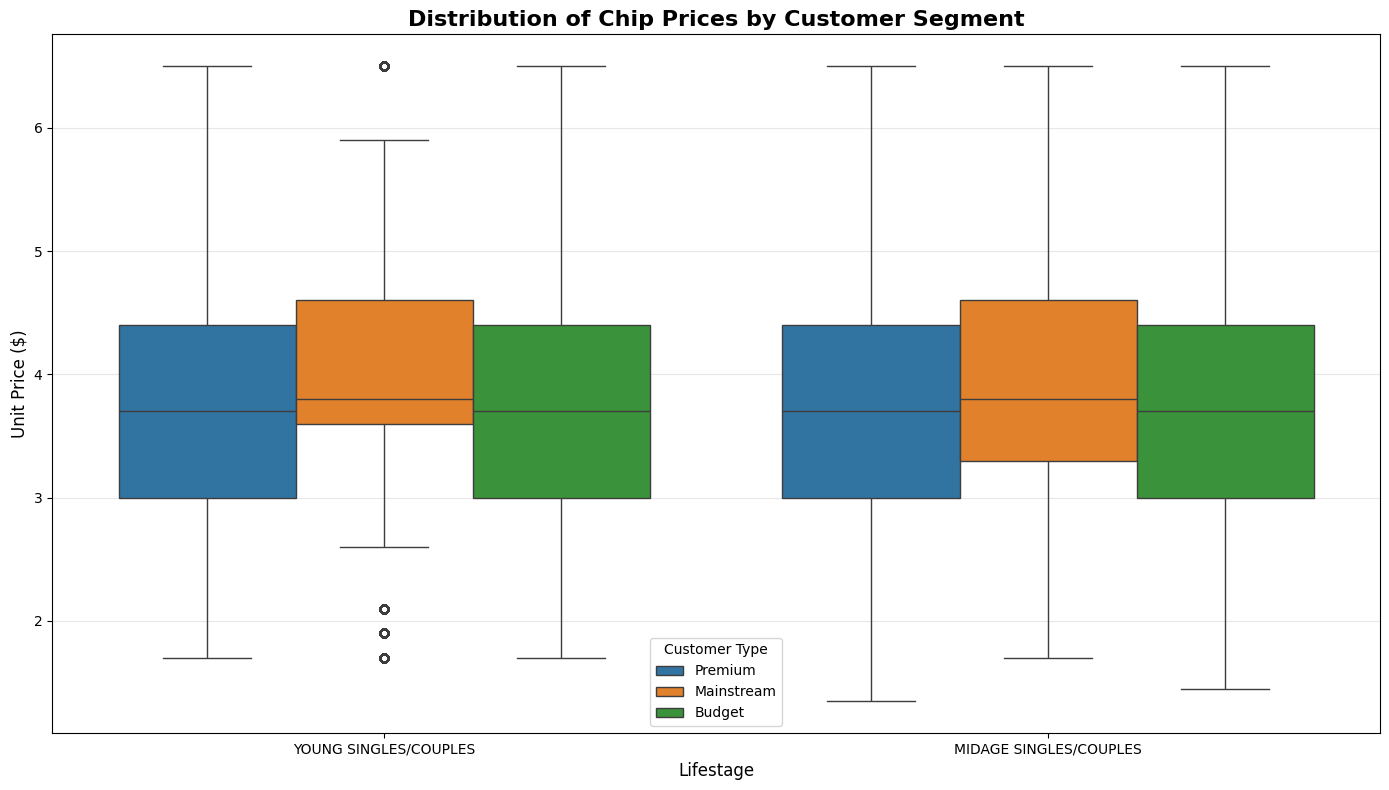

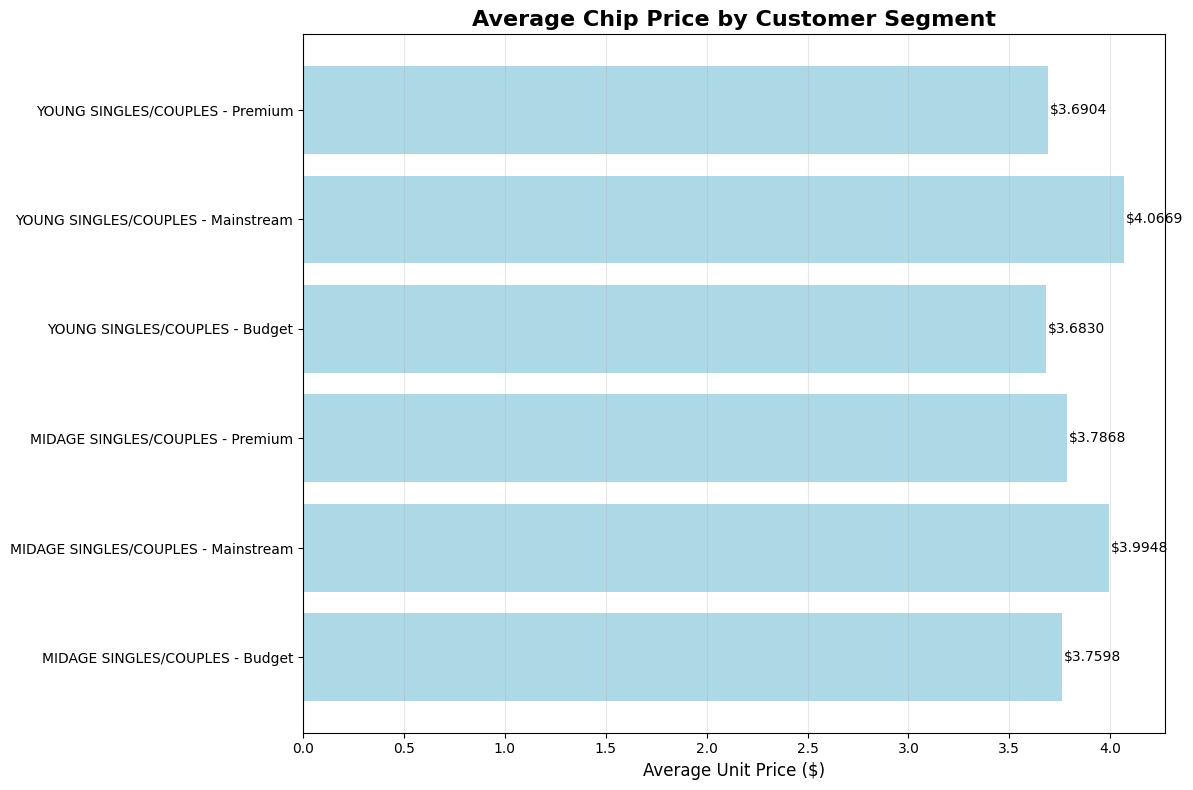

In [43]:
df['unit_price'] = df['TOT_SALES'] / df['PROD_QTY']

# Filter for the segments of interest: Mainstream, Premium, and Budget
# for Midage and Young singles and couples
segments_of_interest = ['MIDAGE SINGLES/COUPLES', 'YOUNG SINGLES/COUPLES']
customer_types = ['Mainstream', 'Premium', 'Budget']

filtered_df = df[
    (df['LIFESTAGE'].isin(segments_of_interest)) & 
    (df['PREMIUM_CUSTOMER'].isin(customer_types))
]

# Create a combined segment column for easier analysis
filtered_df['segment'] = filtered_df['LIFESTAGE'] + ' - ' + filtered_df['PREMIUM_CUSTOMER']

# Check the sample sizes for each segment
segment_counts = filtered_df.groupby('segment').size()
print("Sample sizes for each segment:")
print(segment_counts)
print("\n")

# Perform t-tests between Mainstream vs Premium and Mainstream vs Budget
# For Midage Singles/Couples
midage_mainstream = filtered_df[
    (filtered_df['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES') & 
    (filtered_df['PREMIUM_CUSTOMER'] == 'Mainstream')
]['unit_price']

midage_premium = filtered_df[
    (filtered_df['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES') & 
    (filtered_df['PREMIUM_CUSTOMER'] == 'Premium')
]['unit_price']

midage_budget = filtered_df[
    (filtered_df['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES') & 
    (filtered_df['PREMIUM_CUSTOMER'] == 'Budget')
]['unit_price']

# For Young Singles/Couples
young_mainstream = filtered_df[
    (filtered_df['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & 
    (filtered_df['PREMIUM_CUSTOMER'] == 'Mainstream')
]['unit_price']

young_premium = filtered_df[
    (filtered_df['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & 
    (filtered_df['PREMIUM_CUSTOMER'] == 'Premium')
]['unit_price']

young_budget = filtered_df[
    (filtered_df['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & 
    (filtered_df['PREMIUM_CUSTOMER'] == 'Budget')
]['unit_price']

# Function to perform and print t-test results
def perform_ttest(group1, group2, group1_name, group2_name):
    t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)  # Welch's t-test
    print(f"T-test between {group1_name} and {group2_name}:")
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value: {p_value:.4f}")
    if p_value < 0.05:
        print(f"  Significant difference at α=0.05: YES")
        if t_stat > 0:
            print(f"  {group1_name} pays higher prices than {group2_name}")
        else:
            print(f"  {group2_name} pays higher prices than {group1_name}")
    else:
        print(f"  Significant difference at α=0.05: NO")
    print(f"  Mean {group1_name}: ${group1.mean():.4f}")
    print(f"  Mean {group2_name}: ${group2.mean():.4f}")
    print(f"  Sample sizes: {len(group1)} vs {len(group2)}")
    print("\n")

# Perform the t-tests
print("=== MIDAGE SINGLES/COUPLES ===")
perform_ttest(midage_mainstream, midage_premium, "Midage Mainstream", "Midage Premium")
perform_ttest(midage_mainstream, midage_budget, "Midage Mainstream", "Midage Budget")

print("=== YOUNG SINGLES/COUPLES ===")
perform_ttest(young_mainstream, young_premium, "Young Mainstream", "Young Premium")
perform_ttest(young_mainstream, young_budget, "Young Mainstream", "Young Budget")

# Create a visualization of the price distributions
plt.figure(figsize=(14, 8))
sns.boxplot(x='LIFESTAGE', y='unit_price', hue='PREMIUM_CUSTOMER', data=filtered_df)
plt.title('Distribution of Chip Prices by Customer Segment', fontsize=16, fontweight='bold')
plt.ylabel('Unit Price ($)', fontsize=12)
plt.xlabel('Lifestage', fontsize=12)
plt.legend(title='Customer Type')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Create a bar plot of mean prices by segment
segment_means = filtered_df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['unit_price'].mean().reset_index()
segment_means['segment'] = segment_means['LIFESTAGE'] + ' - ' + segment_means['PREMIUM_CUSTOMER']

plt.figure(figsize=(12, 8))
bars = plt.barh(segment_means['segment'], segment_means['unit_price'], color='lightblue')
plt.title('Average Chip Price by Customer Segment', fontsize=16, fontweight='bold')
plt.xlabel('Average Unit Price ($)', fontsize=12)
plt.grid(axis='x', alpha=0.3)

# Add value labels on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f'${width:.4f}', ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.show()

Number of transactions for Mainstream Young Singles/Couples: 17505

Most frequently purchased brands (support > 0.05):
    support         itemsets
2  0.220211         (Kettle)
0  0.136228        (Doritos)
3  0.132619       (Pringles)
5  0.105866         (Smiths)
6  0.066797          (Thins)
1  0.050985      (Infuzions)
7  0.050985       (Tostitos)
4  0.050126  (Red Rock Deli)

Top association rules (lift > 1):
Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift]
Index: []

Brand preference metrics for Mainstream Young Singles/Couples:
            BRAND  transaction_count  total_quantity  total_sales  avg_price  \
6          Kettle               3844            7172      35423.6   4.939152   
2         Doritos               2378            4447      20925.9   4.705622   
9        Pringles               2315            4326      16006.2   3.700000   
11         Smiths               1848            3361      14620.9   4.350164   
13          Thins               

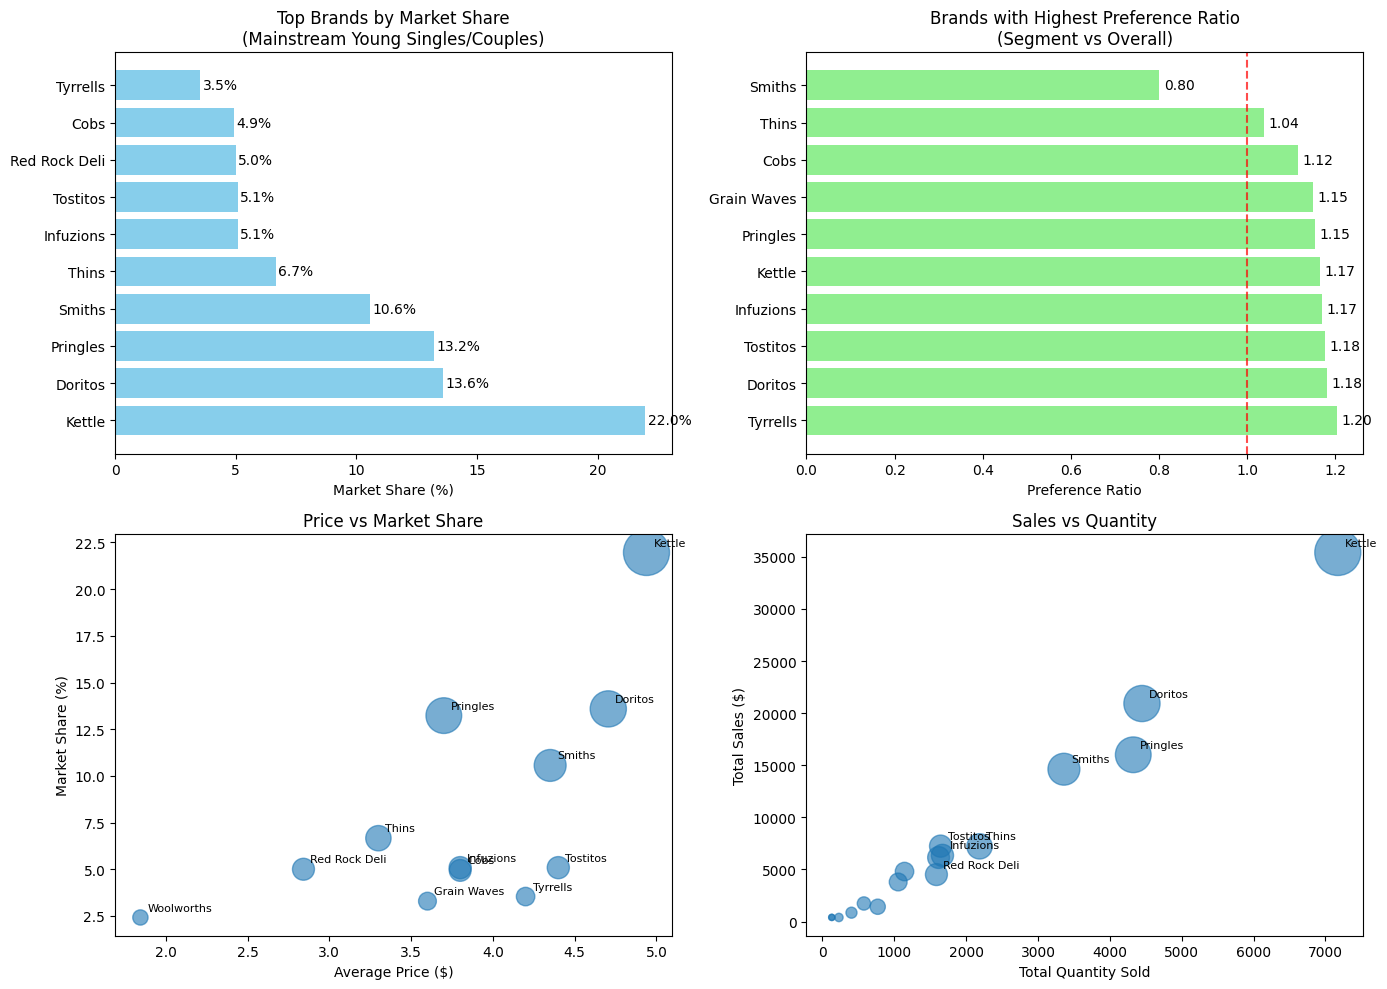


Key Insights:
1. The most popular brand for Mainstream Young Singles/Couples is Kettle with 22.0% market share.
2. The brand with the highest preference ratio is Tyrrells with a ratio of 1.20.
3. This segment shows a preference for Tyrrells, Doritos, Tostitos compared to the overall population.


In [46]:
mainstream_young = df[
    (df['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & 
    (df['PREMIUM_CUSTOMER'] == 'Mainstream')
]

# Check the sample size
print(f"Number of transactions for Mainstream Young Singles/Couples: {len(mainstream_young)}")

# Group by transaction and collect all brands purchased together
transaction_brands = mainstream_young.groupby('TXN_ID')['BRAND'].apply(list).reset_index()

# Prepare data for association rule mining
te = TransactionEncoder()
te_ary = te.fit(transaction_brands['BRAND']).transform(transaction_brands['BRAND'])
brand_df = pd.DataFrame(te_ary, columns=te.columns_)

# Apply Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(brand_df, min_support=0.05, use_colnames=True)
frequent_itemsets = frequent_itemsets.sort_values('support', ascending=False)

print("\nMost frequently purchased brands (support > 0.05):")
print(frequent_itemsets.head(10))

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules = rules.sort_values(['lift', 'confidence'], ascending=[False, False])

print("\nTop association rules (lift > 1):")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

# Calculate brand preference metrics
brand_preference = mainstream_young.groupby('BRAND').agg(
    transaction_count=('TXN_ID', 'nunique'),
    total_quantity=('PROD_QTY', 'sum'),
    total_sales=('TOT_SALES', 'sum'),
    avg_price=('TOT_SALES', lambda x: x.sum() / mainstream_young.loc[x.index, 'PROD_QTY'].sum())
).reset_index()

brand_preference['market_share'] = brand_preference['transaction_count'] / brand_preference['transaction_count'].sum()
brand_preference = brand_preference.sort_values('market_share', ascending=False)

print("\nBrand preference metrics for Mainstream Young Singles/Couples:")
print(brand_preference.head(10))

# Compare with overall population
overall_brand_share = df.groupby('BRAND')['TXN_ID'].nunique().reset_index()
overall_brand_share['overall_share'] = overall_brand_share['TXN_ID'] / overall_brand_share['TXN_ID'].sum()
overall_brand_share = overall_brand_share.rename(columns={'TXN_ID': 'overall_transactions'})

# Merge with segment data
brand_comparison = brand_preference.merge(overall_brand_share[['BRAND', 'overall_share']], on='BRAND', how='left')
brand_comparison['preference_ratio'] = brand_comparison['market_share'] / brand_comparison['overall_share']
brand_comparison = brand_comparison.sort_values('preference_ratio', ascending=False)

print("\nBrands with highest preference ratio (segment vs overall):")
print(brand_comparison[['BRAND', 'market_share', 'overall_share', 'preference_ratio']].head(10))

# Visualization
plt.figure(figsize=(14, 10))

# Top brands by market share in this segment
plt.subplot(2, 2, 1)
top_brands = brand_preference.head(10)
bars = plt.barh(top_brands['BRAND'], top_brands['market_share']*100, color='skyblue')
plt.title('Top Brands by Market Share\n(Mainstream Young Singles/Couples)')
plt.xlabel('Market Share (%)')
# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.1, bar.get_y() + bar.get_height()/2, 
             f'{width:.1f}%', ha='left', va='center')

# Brands with highest preference ratio
plt.subplot(2, 2, 2)
preferred_brands = brand_comparison[brand_comparison['market_share'] > 0.01].head(10)
bars = plt.barh(preferred_brands['BRAND'], preferred_brands['preference_ratio'], color='lightgreen')
plt.title('Brands with Highest Preference Ratio\n(Segment vs Overall)')
plt.xlabel('Preference Ratio')
plt.axvline(x=1, color='red', linestyle='--', alpha=0.7)
# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{width:.2f}', ha='left', va='center')

# Price comparison for top brands
plt.subplot(2, 2, 3)
price_comparison = brand_comparison[brand_comparison['market_share'] > 0.02]
plt.scatter(price_comparison['avg_price'], price_comparison['market_share']*100, 
            s=price_comparison['market_share']*5000, alpha=0.6)
plt.title('Price vs Market Share')
plt.xlabel('Average Price ($)')
plt.ylabel('Market Share (%)')
# Add brand labels
for i, row in price_comparison.iterrows():
    plt.annotate(row['BRAND'], (row['avg_price'], row['market_share']*100), 
                 xytext=(5, 5), textcoords='offset points', fontsize=8)

# Sales vs quantity
plt.subplot(2, 2, 4)
plt.scatter(brand_preference['total_quantity'], brand_preference['total_sales'], 
            s=brand_preference['market_share']*5000, alpha=0.6)
plt.title('Sales vs Quantity')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Total Sales ($)')
# Add brand labels for top brands
for i, row in brand_preference.head(8).iterrows():
    plt.annotate(row['BRAND'], (row['total_quantity'], row['total_sales']), 
                 xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

# Additional insights
print("\nKey Insights:")
print(f"1. The most popular brand for Mainstream Young Singles/Couples is {brand_preference.iloc[0]['BRAND']} with {brand_preference.iloc[0]['market_share']*100:.1f}% market share.")
print(f"2. The brand with the highest preference ratio is {brand_comparison.iloc[0]['BRAND']} with a ratio of {brand_comparison.iloc[0]['preference_ratio']:.2f}.")
print(f"3. This segment shows a preference for {', '.join(brand_comparison.head(3)['BRAND'].tolist())} compared to the overall population.")

Average Pack Size Comparison:
Target Segment (Mainstream Young Singles/Couples): 173.13g
All Other Segments: 171.16g
Overall Average: 171.32g


T-test results for pack size difference:
t-statistic: 4.1739
p-value: 0.0000
The difference in pack size preference is statistically significant (p < 0.05).
Mainstream Young Singles/Couples prefer LARGER pack sizes.


Pack Size Distribution - Target Segment:
pack_size_category
Small (<150g)         42.8%
Medium (150-200g)     45.1%
Large (200-250g)       3.3%
X-Large (250-300g)     0.0%
XX-Large (>300g)       8.8%
Name: proportion, dtype: object

Pack Size Distribution - Other Segments:
pack_size_category
Small (<150g)         40.6%
Medium (150-200g)     49.5%
Large (200-250g)       2.8%
X-Large (250-300g)     0.0%
XX-Large (>300g)       7.1%
Name: proportion, dtype: object


Average Pack Size by Segment:
                 LIFESTAGE PREMIUM_CUSTOMER        mean  count
19   YOUNG SINGLES/COUPLES       Mainstream  173.132534  17505
1   MIDAGE SING

C:\Users\gpari\AppData\Local\Temp\ipykernel_1400\511208390.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_segment['pack_size_category'] = pd.cut(target_segment['PACK_SIZE'], bins=pack_size_bins, labels=pack_size_labels)
C:\Users\gpari\AppData\Local\Temp\ipykernel_1400\511208390.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_segments['pack_size_category'] = pd.cut(other_segments['PACK_SIZE'], bins=pack_size_bins, labels=pack_size_labels)


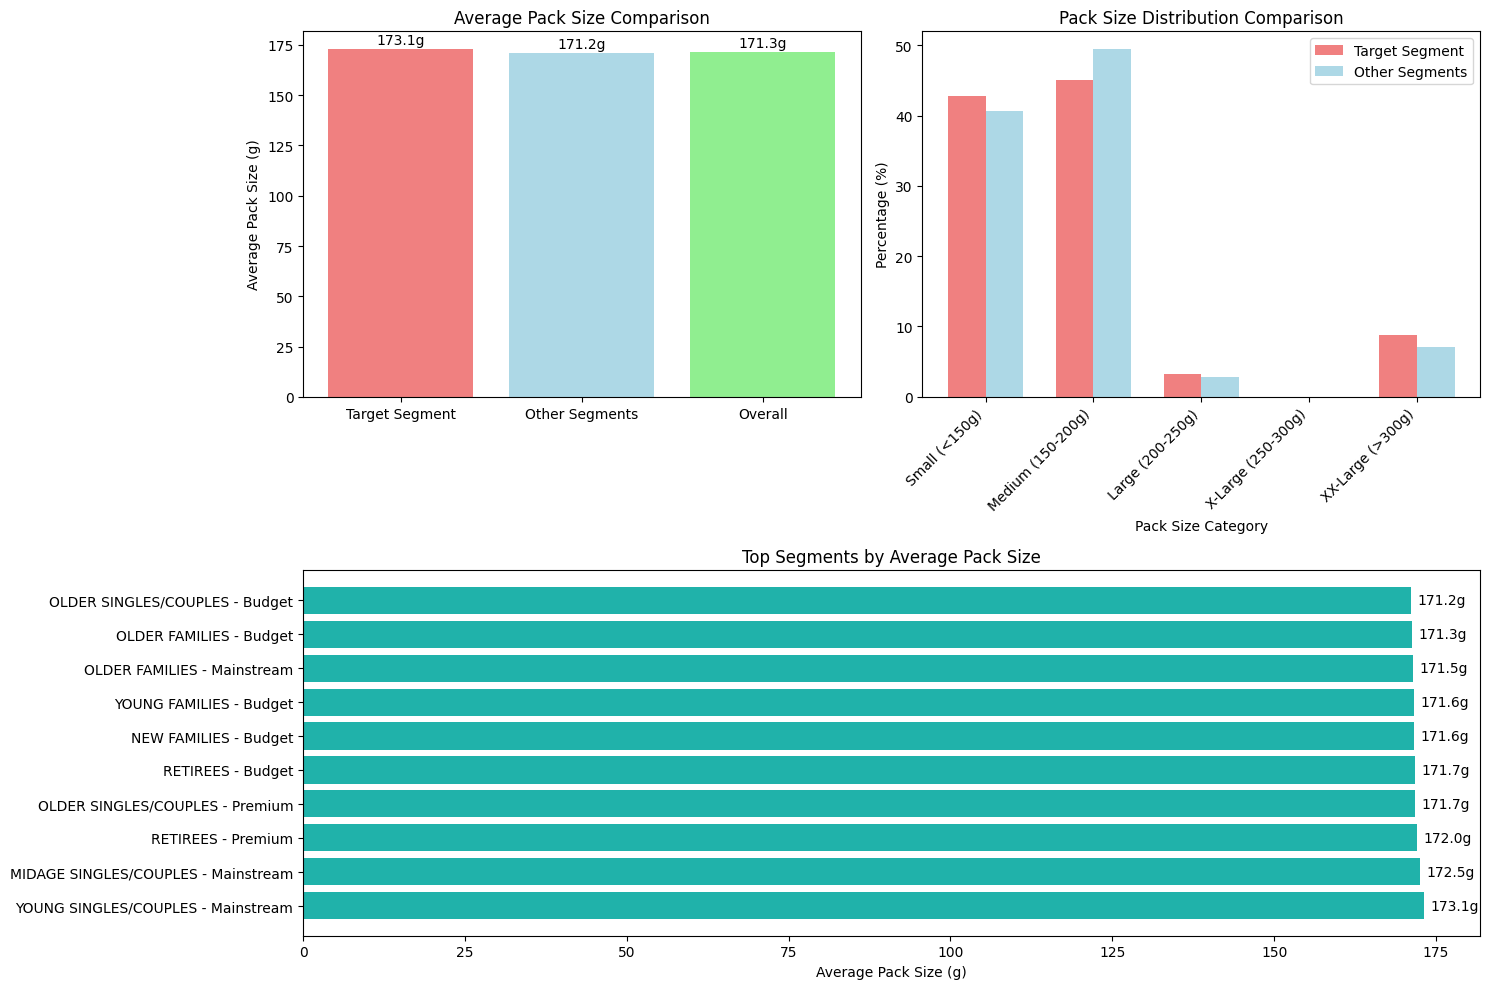


Average Pack Size by Brand (Target Segment):
              BRAND        mean  count
11           Smiths  257.812331   1849
2           Doritos  212.400168   2379
3       Grain Waves  210.000000    576
16       Woolworths  181.040189    423
4       Green Waves  180.000000     70
14         Tostitos  175.000000    890
13            Thins  175.000000   1166
0               CCs  175.000000    222
7               NCC  175.000000     73
8   Natural Chip Co  175.000000    321

Brands with Largest Pack Size Difference (Target vs Overall):
              BRAND        mean  mean_overall  difference
0            Smiths  257.812331    226.765865   31.046466
1           Doritos  212.400168    210.803600    1.596568
12    Red Rock Deli  157.011429    156.807487    0.203941
11           Kettle  160.418835    160.334601    0.084234
9   Natural Chip Co  175.000000    175.000000    0.000000
15        Infuzions  110.000000    110.000000    0.000000
14             Cobs  110.000000    110.000000    0.00000

In [48]:
# Filter for our target segment
target_segment = df[
    (df['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & 
    (df['PREMIUM_CUSTOMER'] == 'Mainstream')
]

# Create comparison groups
other_segments = df[
    ~((df['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & 
    (df['PREMIUM_CUSTOMER'] == 'Mainstream'))
]

# Calculate average pack size for each group
target_avg_pack = target_segment['PACK_SIZE'].mean()
other_avg_pack = other_segments['PACK_SIZE'].mean()
overall_avg_pack = df['PACK_SIZE'].mean()

print("Average Pack Size Comparison:")
print(f"Target Segment (Mainstream Young Singles/Couples): {target_avg_pack:.2f}g")
print(f"All Other Segments: {other_avg_pack:.2f}g")
print(f"Overall Average: {overall_avg_pack:.2f}g")
print("\n")

# Perform t-test to check if the difference is statistically significant
t_stat, p_value = stats.ttest_ind(target_segment['PACK_SIZE'], other_segments['PACK_SIZE'], equal_var=False)

print(f"T-test results for pack size difference:")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("The difference in pack size preference is statistically significant (p < 0.05).")
    if target_avg_pack > other_avg_pack:
        print("Mainstream Young Singles/Couples prefer LARGER pack sizes.")
    else:
        print("Mainstream Young Singles/Couples prefer SMALLER pack sizes.")
else:
    print("The difference in pack size preference is NOT statistically significant.")
print("\n")

# Analyze pack size distribution by segment
pack_size_bins = [0, 150, 200, 250, 300, 400]
pack_size_labels = ['Small (<150g)', 'Medium (150-200g)', 'Large (200-250g)', 'X-Large (250-300g)', 'XX-Large (>300g)']

target_segment['pack_size_category'] = pd.cut(target_segment['PACK_SIZE'], bins=pack_size_bins, labels=pack_size_labels)
other_segments['pack_size_category'] = pd.cut(other_segments['PACK_SIZE'], bins=pack_size_bins, labels=pack_size_labels)

# Calculate percentage distribution
target_pack_dist = target_segment['pack_size_category'].value_counts(normalize=True).sort_index()
other_pack_dist = other_segments['pack_size_category'].value_counts(normalize=True).sort_index()

print("Pack Size Distribution - Target Segment:")
print(target_pack_dist.apply(lambda x: f"{x*100:.1f}%"))
print("\nPack Size Distribution - Other Segments:")
print(other_pack_dist.apply(lambda x: f"{x*100:.1f}%"))
print("\n")

# Compare with specific other segments of interest
segment_comparison = df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['PACK_SIZE'].agg(['mean', 'count']).reset_index()
segment_comparison = segment_comparison.sort_values('mean', ascending=False)

print("Average Pack Size by Segment:")
print(segment_comparison)

# Visualization
plt.figure(figsize=(15, 10))

# 1. Average pack size comparison
plt.subplot(2, 2, 1)
groups = ['Target Segment', 'Other Segments', 'Overall']
values = [target_avg_pack, other_avg_pack, overall_avg_pack]
colors = ['lightcoral', 'lightblue', 'lightgreen']
bars = plt.bar(groups, values, color=colors)
plt.title('Average Pack Size Comparison')
plt.ylabel('Average Pack Size (g)')
# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}g', ha='center', va='bottom')

# 2. Pack size distribution comparison
plt.subplot(2, 2, 2)
x = np.arange(len(pack_size_labels))
width = 0.35
plt.bar(x - width/2, target_pack_dist.values*100, width, label='Target Segment', color='lightcoral')
plt.bar(x + width/2, other_pack_dist.values*100, width, label='Other Segments', color='lightblue')
plt.xlabel('Pack Size Category')
plt.ylabel('Percentage (%)')
plt.title('Pack Size Distribution Comparison')
plt.xticks(x, pack_size_labels, rotation=45, ha='right')
plt.legend()
plt.tight_layout()

# 3. Top segments by pack size
plt.subplot(2, 1, 2)
top_segments = segment_comparison.head(10)
bars = plt.barh(top_segments['LIFESTAGE'] + ' - ' + top_segments['PREMIUM_CUSTOMER'], 
                top_segments['mean'], color='lightseagreen')
plt.title('Top Segments by Average Pack Size')
plt.xlabel('Average Pack Size (g)')
# Add value labels on bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2,
             f'{width:.1f}g', ha='left', va='center')

plt.tight_layout()
plt.show()

# Additional analysis: Pack size by brand for the target segment
brand_pack_size = target_segment.groupby('BRAND')['PACK_SIZE'].agg(['mean', 'count']).reset_index()
brand_pack_size = brand_pack_size[brand_pack_size['count'] > 10]  # Filter for brands with sufficient data
brand_pack_size = brand_pack_size.sort_values('mean', ascending=False)

print("\nAverage Pack Size by Brand (Target Segment):")
print(brand_pack_size.head(10))

# Compare with overall brand pack sizes - FIXED CODE
overall_brand_pack = df.groupby('BRAND')['PACK_SIZE'].mean().reset_index()
overall_brand_pack = overall_brand_pack.rename(columns={'PACK_SIZE': 'mean_overall'})
brand_comparison = brand_pack_size.merge(overall_brand_pack, on='BRAND')
brand_comparison['difference'] = brand_comparison['mean'] - brand_comparison['mean_overall']
brand_comparison = brand_comparison.sort_values('difference', ascending=False)

print("\nBrands with Largest Pack Size Difference (Target vs Overall):")
print(brand_comparison[['BRAND', 'mean', 'mean_overall', 'difference']].head(10))

### Conclusion
Sales have mainly been due to Budget - older families, Mainstream - young singles/couples, and Mainstream retirees shoppers. We found that the high spend in chips for mainstream young singles/couples and retirees is due to there being more of them than other buyers. Mainstream, midage and young singles and
couples are also more likely to pay more per packet of chips. This is indicative of impulse buying behaviour.
We’ve also found that Mainstream young singles and couples are 23% more likely to purchase Tyrrells chips
compared to the rest of the population. The Category Manager may want to increase the category’s performance by off-locating some Tyrrells and smaller packs of chips in discretionary space near segments
where young singles and couples frequent more often to increase visibilty and impulse behaviour